# 02b - Comparing the adsorption sites and extrapolation performance

This notebook reproduces Figs. 2b,c from the manuscript, and Fig. S7 from the Supporting Information. The data in this notebook compares the adsorption sites of Cu facets using the SOAP representation.

In [1]:
from basics import *
from plotting import *
import seaborn as sns
from scipy import stats
from dscribe.descriptors import SOAP
from pymatgen.core import Structure, Molecule
from pymatgen.io.ase import AseAtomsAdaptor
from mkite_catalysis.runners.coverage import CoverageGenerator
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from scipy.stats import percentileofscore
import umap

plt.style.use("paper")

In [2]:
FACETS = [100, 111, 211, 331, 410, 711]

cutoffs = {
    111: 1.0,
    100: 1.0,
    211: 1.4,
    331: 1.6,
    410: 1.2,
    711: 1.8
}

COLORS = {
    100: cm.tab10(0),
    111: cm.tab10(1),
    211: cm.tab10(2),
    331: cm.tab10(3),
    410: cm.tab10(4),
    711: cm.tab10(5)
}

crystals = {
    facet: Structure.from_file(f"../data/01-facets/{facet}.POSCAR")
    for facet in cutoffs.keys()
}

pos = np.array([
    [0, 0, -0.5641],
    [0, 0,  0.5641],
])
ads = Molecule(species=["C", "O"], coords=pos)

## SOAP vectors

In [3]:
soap = SOAP(
    r_cut=5.0,
    n_max=7,
    l_max=6,
    sigma=0.3,
    species=["Cu"],
    periodic=True
)

In [4]:
vecs, labels = [], []

for facet, s in crystals.items():
    cutoff = cutoffs.get(facet, 0.9)
    cgen = CoverageGenerator(s, ads, surface_height=cutoff)
    finder = cgen.get_finder()
    sites = np.array(finder.find_adsorption_sites(distance=2.0)["all"])
    
    at = AseAtomsAdaptor.get_atoms(s)
    v = soap.create(at, centers=list(sites))
    
    vecs += [v]
    labels += [facet] * len(sites)

vecs = np.concatenate(vecs, axis=0)

## UMAP

/opt/homebrew/Caskroom/miniconda/base/envs/mkite/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/pk/bysbkx9j3993c_vqdsykcn680000gn/T/ipykernel_37051/2836574112.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xy[idx, 0], xy[idx, 1], c=COLORS[facet], s=40, edgecolors="k", linewidth=0.3, alpha=1.0)


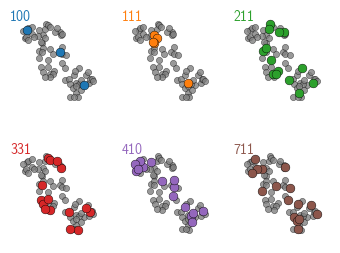

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(3.5, 3.0), sharex=True, sharey=True)

reducer = umap.UMAP(metric="cosine", random_state=6)
xy = reducer.fit_transform(vecs)

colors = [COLORS[f] for f in labels]
label_set = sorted(list(set(labels)))

pad = 1
xlim = (xy[:, 0].min() - pad, xy[:, 0].max() + pad)
ylim = (xy[:, 1].min() - pad, xy[:, 1].max() + pad)

for i, ax in enumerate(axs.ravel()):
    ax.scatter(xy[:, 0], xy[:, 1], c="#808080", s=20, edgecolors="k", linewidth=0.3, alpha=0.8)
    
    facet = label_set[i]
    idx = [l == facet for l in labels]
    ax.scatter(xy[idx, 0], xy[idx, 1], c=COLORS[facet], s=40, edgecolors="k", linewidth=0.3, alpha=1.0)

    ax.set_aspect("equal")
    for spine in ["left", "right", "top", "bottom"]:
        ax.spines[spine].set_visible(False)
    
    ax.annotate(facet, (0.00, 0.90), xycoords="axes fraction", color=COLORS[facet])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

fig.tight_layout()
savefig(fig, "03-extrapolation-umap.pdf")
plt.show()

## Analyzing distances

In [6]:
sim = cosine_similarity(vecs)
sim_dist = sim[np.triu_indices_from(sim, k=1)]
dm = np.sqrt(2 - 2 * sim.clip(0, 1))

indices = {
    k: [x == k for x in labels]
    for k in FACETS
}

In [7]:
overlaps = []

for f1, f2 in itertools.product(FACETS, repeat=2):
    i1, i2 = indices[f1], indices[f2]
    submatrix = sim[i1][:, i2]
    
    max_sim = submatrix.max(1).min()
    overlaps.append({"f1": f1, "f2": f2, "max_sim": max_sim})

overlaps = pd.DataFrame(overlaps)

In [8]:
ov_table = overlaps.pivot(index="f1", columns="f2", values="max_sim")

In [9]:
pct_table = pd.DataFrame(
    percentileofscore(sim_dist, ov_table),
    columns=ov_table.columns,
    index=ov_table.index
)

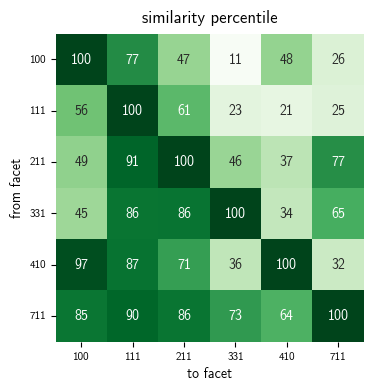

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.heatmap(
    pct_table.T,
    annot=True,
    fmt=".0f",
    cbar=False,
    square=True,
    ax=ax,
    cmap="Greens"
)

ax.set_xlabel("to facet")
ax.set_ylabel("from facet")
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)

ax.set_title("similarity percentile")
savefig(fig, "03-extrapolation-similarity-table.pdf")
plt.show()

In [11]:
rmse = pd.read_csv("../data/03-mace-extrapolation/mace.csv", index_col=0)
rmse = rmse.loc[rmse.exp == "facet"].pivot(index="test_facet", columns="train_facet", values="rmse")

/var/folders/pk/bysbkx9j3993c_vqdsykcn680000gn/T/ipykernel_37051/1086688178.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(_x, _y, c=COLORS[facet], s=10)


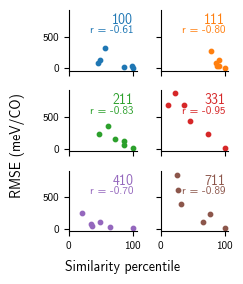

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(2.5, 3.0), sharex=True, sharey=True)

for facet, ax in zip(FACETS, axs.ravel()):
    _y = rmse.loc[facet] * 1000
    _x = pct_table.loc[facet]
    r, _ = stats.pearsonr(_x, _y)
    ax.scatter(_x, _y, c=COLORS[facet], s=10)
    ax.annotate(facet, (0.95, 0.95), xycoords="axes fraction", ha="right", va="top", color=COLORS[facet])
    ax.annotate(
        f"r = {r:.2f}",
        (0.95, 0.75),
        xycoords="axes fraction",
        ha="right", va="top",
        color=COLORS[facet],
        fontsize=8
    )
    ax.set_xlim(0, 105)
    
fig.supxlabel("Similarity percentile", fontsize=10, y=0.07)
fig.supylabel("RMSE (meV/CO)", fontsize=10, x=0.05)

fig.tight_layout()
savefig(fig, "03-extrapolation-similarity-corr.pdf")
plt.show()